# ACME

**Business Question**

Is it possible to leverage automated dialogue summarization while ensuring that summaries remain accurate, concise, and aligned with user expectations?

**Task**
Implement an encoder-decoder architecture using pre-trained BERT models to generate accurate and concise summaries of these conversations. This project will test your ability to implement and fine-tune a pre-trained language model for a specific NLP task.

## Detailed Plan

Bold letters are the steps covered in ths notebook

1.	**Data Ingestion & Splitting. Load Dataset, it is already into train (90%), validation (5%), and test (5%). Then, verify data quality, label integrity and clean.**

2.	**Descriptive Analytics & KPIs. Run basic stats and define evaluation KPIs like ROUGE-Lsum, summary length and compression ratio to guide model selection and track progress.**

3.	**Model Selection (Baseline Shootout). Benchmark BERT2BERT vs GPT-2 under the same preprocessing and decoding setup; select the stronger baseline using ROUGE-Lsum plus quick qualitative checks.**

4.	Phase A — Training Optimization. Tune core training hyperparameters (learning rate, weight decay, label smoothing, warmup) with a data subset to establish the best fine-tuned checkpoint.

5.	Phase B — Decoding Optimization (Inference Only). Run a full-validation grid over num_beams, length_penalty, no_repeat_ngram_size, max_new_tokens to improve output quality without retraining.

6.	Targeted Case Reviews. Assess faithfulness and tone on three representative examples (idx 654, 114, 25) to validate real-world usefulness beyond metrics.

7.	Final Diagnostics & Readiness Check. Summarize length distributions, compression ratios, and generated vs. reference comparisons; document risks and guardrails to ensure summaries are concise, accurate, and deployment ready.


# STEP 1: Dataset Exploration and Preparation

### 1.1 Load the SAMSum dataset and explore its structure.

In [ ]:
!pip install -q evaluate rouge_score nltk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorForSeq2Seq, EncoderDecoderModel, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoModel, AutoConfig, AutoModelForCausalLM, AutoTokenizer, EarlyStoppingCallback
import evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
dataset = load_dataset("knkarthick/samsum")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

In [ ]:
# SAMSum Dataset Sizes
print("=== SAMSum Dataset Split Sizes ===")
print(f"Train: {len(dataset['train'])}")
print(f"Validation: {len(dataset['validation'])}")
print(f"Test: {len(dataset['test'])}")

=== SAMSum Dataset Split Sizes ===
Train: 14732
Validation: 818
Test: 819


In [ ]:
# Percentages of each split
train_n = len(dataset["train"])
val_n   = len(dataset["validation"])
test_n  = len(dataset["test"])
total   = train_n + val_n + test_n

def pct(n):
    return 0.0 if total == 0 else (100.0 * n / total)

print("\n=== SAMSum Split Percentages ===")
print(f"Train:      {pct(train_n):.2f}%  ({train_n}/{total})")
print(f"Validation: {pct(val_n):.2f}%  ({val_n}/{total})")
print(f"Test:       {pct(test_n):.2f}%  ({test_n}/{total})")


=== SAMSum Split Percentages ===
Train:      90.00%  (14732/16369)
Validation: 5.00%  (818/16369)
Test:       5.00%  (819/16369)


In [ ]:
# Show the first 3 rows from the train split
print(dataset["train"][:1])

{'id': ['13818513'], 'dialogue': ["Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)"], 'summary': ['Amanda baked cookies and will bring Jerry some tomorrow.']}


In [ ]:
# Show the first 3 rows from the train Validation
print(dataset["validation"][:1])

{'id': ['13817023'], 'dialogue': ["A: Hi Tom, are you busy tomorrow’s afternoon?\nB: I’m pretty sure I am. What’s up?\nA: Can you go with me to the animal shelter?.\nB: What do you want to do?\nA: I want to get a puppy for my son.\nB: That will make him so happy.\nA: Yeah, we’ve discussed it many times. I think he’s ready now.\nB: That’s good. Raising a dog is a tough issue. Like having a baby ;-) \nA: I'll get him one of those little dogs.\nB: One that won't grow up too big;-)\nA: And eat too much;-))\nB: Do you know which one he would like?\nA: Oh, yes, I took him there last Monday. He showed me one that he really liked.\nB: I bet you had to drag him away.\nA: He wanted to take it home right away ;-).\nB: I wonder what he'll name it.\nA: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))"], 'summary': ['A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy. ']

In [ ]:
# Show the first 3 rows from the tets split
print(dataset["test"][:1])

{'id': ['13862856'], 'dialogue': ["Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"], 'summary': ["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."]}


## 1.2 Analyze the characteristics of the dialogues and summaries EDA

### Data Quality



In [ ]:
# Count None values in dialogues and summaries
none_dialogues = sum(1 for d in dataset["train"]["dialogue"] if d is None)
none_summaries = sum(1 for s in dataset["train"]["summary"] if s is None)

print("=== Missing Values in Train Split ===")
print(f"Dialogues with None: {none_dialogues}")
print(f"Summaries with None: {none_summaries}")

=== Missing Values in Train Split ===
Dialogues with None: 1
Summaries with None: 0


There is 1 row in summary with None



In [ ]:
# Find index(es) with None dialogues
bad_idx = [i for i, d in enumerate(dataset["train"]["dialogue"]) if d is None]
print("Indices with None dialogue:", bad_idx)

# (Optional) peek at other fields for that row
if bad_idx:
    ex = dataset["train"][bad_idx[0]]
    print("Example metadata:", {k: ex[k] for k in ex if k != "dialogue"})

Indices with None dialogue: [6054]
Example metadata: {'id': '13828807', 'summary': 'problem with visualization of the content'}


**Handling Missing Dialogue Entries**

During dataset inspection, we identified one instance in the training split (index 6054) where the dialogue field was missing (None) while the summary field remained populated. This represents less than 0.01% of the training data (1 out of 14,732 examples).

We considered two possible remediation strategies:

Replacing the missing dialogue with its summary: This approach would leak the gold-standard label into the input, violating the input–output independence assumption. It would also distort the natural length ratio between dialogues and summaries, introducing unrealistic patterns that the model could overfit to.

Dropping the sample: Eliminating this single example preserves dataset integrity without materially impacting model performance, given the extremely small proportion affected.

**Decision:**
We dropped the instance with the missing dialogue. This ensures the dataset remains internally consistent and avoids introducing artifacts that could bias the summarization model.

In [ ]:
train = dataset["train"]
print("Train size before cleaning:", len(train))

train = train.filter(lambda ex: ex["dialogue"] is not None)
print("Train size after cleaning:", len(train))

Train size before cleaning: 14732


Filter:   0%|          | 0/14732 [00:00<?, ? examples/s]

Train size after cleaning: 14731


In [ ]:
# Count None values in dialogues and summaries
none_dialogues = sum(1 for d in dataset["validation"]["dialogue"] if d is None)
none_summaries = sum(1 for s in dataset["validation"]["summary"] if s is None)

print("=== Missing Values in Validation Split ===")
print(f"Dialogues with None: {none_dialogues}")
print(f"Summaries with None: {none_summaries}")

=== Missing Values in Validation Split ===
Dialogues with None: 0
Summaries with None: 0


In [ ]:
validation = dataset["validation"]

In [ ]:
# Count None values in dialogues and summaries
none_dialogues = sum(1 for d in dataset["test"]["dialogue"] if d is None)
none_summaries = sum(1 for s in dataset["test"]["summary"] if s is None)

print("=== Missing Values in Test Split ===")
print(f"Dialogues with None: {none_dialogues}")
print(f"Summaries with None: {none_summaries}")

=== Missing Values in Test Split ===
Dialogues with None: 0
Summaries with None: 0


In [ ]:
test = dataset["test"]

Only one instance with a missing dialogue was found in the training set (index 6054). This was dropped to preserve data integrity. The validation and test splits contained no missing values, so no further cleaning was necessary

### Describe the Data

**Train Dataset**

In the following exploratory analysis, we will focus on the training split, as this subset directly informs model learning and preprocessing design. Statistics such as dialogue length, number of turns, and summary compression ratios will be derived from the training data to guide decisions on tokenization strategy and maximum sequence lengths.

For the validation and test splits, only a data-integrity check is required (ensuring no missing dialogues or summaries). Since these splits are reserved for hyperparameter tuning and final evaluation, exhaustive EDA is unnecessary; this approach keeps the analysis unbiased while confirming dataset quality across all partitions.

In [ ]:
# Define helpful functions for dialogues and summaries

def word_count(s):
    return len(s.split())

# Count the number of non-empty lines in a dialogue
def num_turns(dialogue):
    # count non-empty lines as turns
    return sum(1 for line in dialogue.splitlines() if line.strip())

In [ ]:
# Create a DataFrame (train_stats) with key statistics for EDA:

train_stats = pd.DataFrame({
    "dialogue_len_chars": [len(d) for d in train["dialogue"]],                  # - dialogue length (characters)
    "dialogue_len_words": [word_count(d) for d in train["dialogue"]],          # - dialogue length (words)
    "turns":               [num_turns(d) for d in train["dialogue"]],         # - number of speaker turns, basically the numbers of entries
    "summary_len_words":   [word_count(s) for s in train["summary"]],        # - summary length (words)
})

In [ ]:
# Describe Test
stats = train_stats.describe(percentiles=[0.5, 0.75, 0.9, 0.95]).round(2)
print("=== Basic stats (train) ===")
print(stats)

=== Basic stats (train) ===
       dialogue_len_chars  dialogue_len_words     turns  summary_len_words
count            14731.00            14731.00  14731.00           14731.00
mean               502.31               93.79     11.17              20.32
std                397.64               74.03      6.45              11.15
min                 29.00                7.00      3.00               1.00
50%                392.00               73.00     10.00              18.00
75%                681.00              128.00     15.00              27.00
90%               1018.00              191.00     20.00              37.00
95%               1271.50              237.00     24.00              43.00
max               5474.00              803.00     46.00              64.00


In [ ]:
# Show first 5 rows of the train split as a DataFrame
pd.DataFrame(train[:5])

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\nJ...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\nSam: i...,"Sam is confused, because he overheard Rick com..."


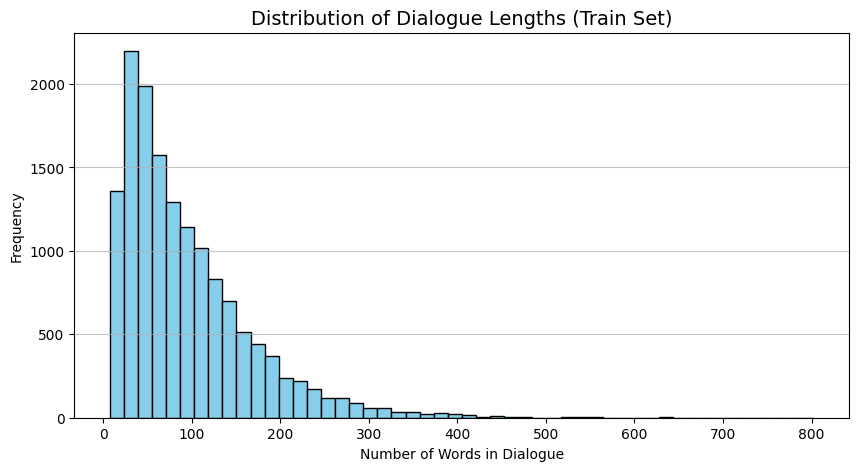

In [ ]:
# Histogram of dialogue lengths (in # of words)
plt.figure(figsize=(10, 5))
plt.hist(train_stats["dialogue_len_words"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Dialogue Lengths (Train Set)", fontsize=14)
plt.xlabel("Number of Words in Dialogue")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

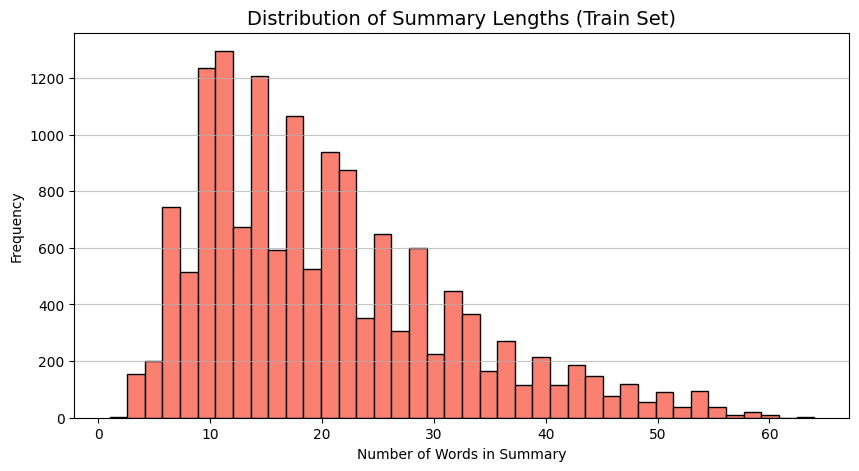

In [ ]:
# Histogram of summary lengths (in # of words)
plt.figure(figsize=(10, 5))
plt.hist(train_stats["summary_len_words"], bins=40, color="salmon", edgecolor="black")
plt.title("Distribution of Summary Lengths (Train Set)", fontsize=14)
plt.xlabel("Number of Words in Summary")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

**Key Observations**

Dialogue Lengths: Most dialogues are relatively short, concentrated below 100 words. The distribution has a long tail while the majority are short exchanges, some dialogues extend to 400 - 800 words, reflecting highly variable conversational depth. This variability confirms why we will set a max input length of 512 tokens during tokenization (covers nearly all cases).

Summary Lengths: Human-written summaries are much shorter, typically 10 to 30 words. The peak around 10 to 15 words shows that summaries are concise, often only 1-2 sentences. Very few summaries exceed 50 words, reinforcing the choice of max target length = 128 tokens.

Compression Ratio: Comparing the two histograms highlights that summaries are consistently 5-10 times shorter than dialogues. This supports the earlier finding of a compression ratio ~0.15 - 0.20, demonstrating that the summarization task requires distilling long inputs into very compact outputs.

### Turn Distribution

Following, I designed some metrics based what is relevant to the stakeholder and the business goal

In [ ]:
# Calculate additional aggregated measures:

avg_words_per_dialogue = train_stats["dialogue_len_words"].mean()   # average words in a dialogue
avg_words_per_turn = (train_stats["dialogue_len_words"]/train_stats["turns"]).replace([np.inf, np.nan], 0).mean() # - average words per speaker turn
comp_ratio = (train_stats["summary_len_words"]/train_stats["dialogue_len_words"]).mean()         # - compression ratio (summary words / dialogue words)

print(f"Avg words per dialogue: {avg_words_per_dialogue:.2f}")
print(f"Avg words per speaker turn: {avg_words_per_turn:.2f}")
print(f"Avg compression ratio (summary_words / dialogue_words): {comp_ratio:.3f}")

Avg words per dialogue: 93.79
Avg words per speaker turn: 8.03
Avg compression ratio (summary_words / dialogue_words): 0.296


Basically, the dialogue is compressed to about 30% of te original

If the dialogue average is about 8 words, so the average power of reduction is  2-3 words per turn to talk

### Length variability & Edge Cases

Check the longest and shortest dialogues

In [ ]:
# show shortest and longest dialogue in the train split
short_i = int(train_stats["dialogue_len_words"].idxmin())
long_i  = int(train_stats["dialogue_len_words"].idxmax())

print("\n--- Shortest dialogue sample ---")
print(train[short_i]["dialogue"])
print("\nSummary:", train[short_i]["summary"])

print("\n--- Longest dialogue (first 500 chars) ---")
print(train[long_i]["dialogue"][:500] + " ...")
print("\nSummary:", train[long_i]["summary"])


--- Shortest dialogue sample ---
Bella: pizza?
Bella: or pasta?
Mick: pizza

Summary: Bella and Mick will have pizza.

--- Longest dialogue (first 500 chars) ---
Ash: Thanks so much! I am feeling so much better. I'm gonna work on the next chapter as soon as I can. I'm hoping to actually work on it tonight, but I have to beta another story. Thanks again!!!
Mollie: Please do! I love all your stories but this one cuts the cake. :) I'm glad to hear you're feeling better :D and have fun Beta-ing! :P
Mollie: P.S. Can I ask dor a small-ish favour? Could you make Clara say (in that last chapter): "run you clever boy" or something like that? If not I get it :P
As ...

Summary: Ash is feeling better and he will work on the next chapter as soon as he can. He has to beta another story tonight. Mollie likes all of his stories. 


Examination of the shortest and longest dialogues in the training split highlights the wide variability of the dataset. At one extreme, conversations can be as short as three words, while at the other they span several hundred words across multiple speaker turns. Despite this variation, summaries remain concise, typically condensing long exchanges into just a few sentences. This reinforces the need to set relatively high maximum input lengths (to accommodate long dialogues) while maintaining much shorter maximum target lengths for summaries, reflecting the natural compression present in the data.

### Vocabulary richness:

How many unique words in my train dataset

In [ ]:
# Count size of vocabulary (unique words)
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
vectorizer.fit(train["dialogue"])
unique_words = len(vectorizer.vocabulary_)

print(f"\nUnique words in dialogues: {unique_words}")


Unique words in dialogues: 28935


After removing common English stopwords, the training dialogues contained approximately 28,935 unique words. This relatively large vocabulary reflects the informal, varied nature of the conversations, including personal names, abbreviations, and colloquial expressions

**Summary**

Data source & quality: We used the SAMSum dataset (train/validation/test including human-written summaries). One record in the test split had an empty dialogue and was removed and validation and test are clean. We kept seed and versions fully documented for reproducibility.

Scale & composition: The training set contains 14,731 conversations with 28,935 unique words in dialogues. Typical chats are short: ~94 words per dialogue and ~8 words per turn with median of 10 turns. Human summaries are concise: median 18 words, with an average compression ratio ≈ 0.28–0.30 (summary words / dialogue words).

These exploratory findings provided the foundation for preprocessing choices in Step 1.3, particularly in setting appropriate maximum input and output lengths, designing tokenization, and ensuring that the dataset is clean and representative for model training.

## 1.3 Prepare the data for input to the BERT model

We used the WordPiece tokenizer packaged with the checkpoint patrickvonplaten/bert2bert_cnn_daily_mail to ensure full compatibility between tokenization and model embeddings. Using the paired tokenizer avoids vocabulary mismatches, guarantees that special tokens (e.g., [CLS], [SEP], [PAD]) align with model configuration, and ensures consistent handling of input dialogues and output summaries.

**I folloowed strictly the Flatiron instructions and steps suggested**

### 1.3.a Implement appropriate tokenization.

Since SAMSum already comes with splits test and validation, then we tokenize those two

Model choice: We selected the pretrained BERT2BERT tokenizer (patrickvonplaten/bert2bert_cnn_daily_mail) because Step 2.1 requires implementing an encoder–decoder architecture with BERT. This tokenizer ensures consistency between the encoder (dialogues) and decoder (summaries), as both use the same WordPiece vocabulary.

Maximum input length (512 tokens): Exploratory analysis revealed that some dialogues extend to several hundred words across many speaker turns. Setting the input length to 512 tokens allows the model to capture these longer conversations without truncating important context. This length is also aligned with BERT’s architectural limit.

Maximum target length (128 tokens): Human-written summaries in the dataset are short and highly compressed, typically 1–3 sentences (~20–40 words). By capping summaries at 128 tokens, we provide ample room to cover the longest summaries observed while avoiding unnecessary padding.

Alignment with EDA: These parameter choices were directly informed by our exploration of dialogue lengths, turn distributions, and compression ratios. They strike a balance between preserving essential context, respecting model constraints, and maintaining computational efficiency.

In [ ]:
# Guided by EDA: long inputs, short outputs
model_name     = "patrickvonplaten/bert2bert_cnn_daily_mail"  # tokenizer for BERT2BERT; model comes later in Step 2
max_input_len  = 512
max_target_len = 128

In [ ]:
# define tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [ ]:
# Helper functions Preprocessing

def preprocess(batch):
    # Encode dialogues (inputs to encoder)
    enc = tokenizer(
        batch["dialogue"],
        max_length=max_input_len,
        truncation=True,
        padding=False,
    )
    # Encode summaries (labels for decoder)
    dec = tokenizer(
        text_target=batch["summary"],
        max_length=max_target_len,
        truncation=True,
        padding=False,
    )
    enc["labels"] = dec["input_ids"]         # This line was added as part of 3.2, used by cross-entropy loss
    return enc

The helperfunction turns each raw example into exactly what the model needs—tokenized inputs and target labels. Keeping this in one small function means: the same steps run for train/val/test (consistent and reproducible), labels are attached so the Trainer can compute cross-entropy automatically
and we can use datasets.map(batched=True) for fast, clean preprocessing without copy-paste code.

### 1.3.b Create training and validation splits.

Unlike earlier computer vision labs (Flatiron) where images were loaded from directories and splits created manually, the SAMSum dataset comes pre-partitioned into train/validation/test sets through Hugging Face Datasets. Instead of image_dataset_from_directory, we rely on Hugging Face’s .map() function and a sequence-to-sequence data collator to prepare batches of tokenized dialogues and summaries. This reflects the fundamental difference between classification tasks (fixed labels per sample) and abstractive summarization (text generation).

In [ ]:
# Tokenize TRAIN split

tokenized_train = train.map(
    preprocess,                       # uses the tokenizer & lengths we juts built
    batched=True,                     # process in mini-batches for speed
    remove_columns=train.column_names,# drop raw text columns in this tokenized view
    desc="Tokenizing train (BERT2BERT)")

print("Tokenized train — cols:", tokenized_train.column_names, "| size:", len(tokenized_train))

Tokenizing train (BERT2BERT):   0%|          | 0/14731 [00:00<?, ? examples/s]

Tokenized train — cols: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'] | size: 14731


In [ ]:
# Tokenize VALIDATION split

tokenized_val = validation.map(
    preprocess,
    batched=True,
    remove_columns=validation.column_names,
    desc="Tokenizing validation (BERT2BERT)")

print("Tokenized val — cols:", tokenized_val.column_names, "| size:", len(tokenized_val))

Tokenizing validation (BERT2BERT):   0%|          | 0/818 [00:00<?, ? examples/s]

Tokenized val — cols: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'] | size: 818


### 1.3.c Build data loaders for efficient model training.

**Resource-aware development (Flatiron considerations)**

To balance iteration speed with model quality, we begin with a small subset of the tokenized train/validation splits (e.g., ~800/200 examples). This aligns with Flatiron’s guidance to prototype on a reduced dataset because training transformer models is computationally intensive. The subset enables fast end-to-end smoke tests (tokenization → dataloaders → training loop), early detection of bugs, and rapid tuning of batch size, sequence lengths, and optimization settings.

Random seed fixed for reproducibility, confirming stable learning curves and reasonable validation metrics, so the full dataset is scaled.

This staged approach minimizes wasted compute, shortens feedback cycles, and keeps the focus on design choices (e.g., decoding strategy such as beam search) that most affect performance.

In [ ]:
# Choose which tokenized splits to use:
USE_SMALL_SUBSET = True

if USE_SMALL_SUBSET:
    tokenized_train_run = tokenized_train.select(range(min(800, len(tokenized_train))))
    tokenized_val_run   = tokenized_val.select(range(min(200, len(tokenized_val))))
else:
    tokenized_train_run = tokenized_train
    tokenized_val_run   = tokenized_val

In [ ]:
# Set PyTorch tensor format on the columns we need

cols = ["input_ids", "attention_mask", "labels"]                   # token IDs for the encoder (dialogue)
tokenized_train_run.set_format(type="torch", columns=cols)
tokenized_val_run.set_format(type="torch", columns=cols)

To optimize resource usage and training speed, only the columns required for model learning (input_ids, attention_mask, labels) were retained and converted to PyTorch tensors. This ensures that every sample returned by the DataLoader is ready for GPU training without extra conversion steps, reducing overhead and aligning with Flatiron’s guidance on resource-aware experimentation

In [ ]:
# Data collator for seq2seq does dynamic padding per batch
#    - avoids massive zero-padding for long dialogues
#    - sets label pad tokens to -100 so they are ignored by the loss
# Padding is inserting [PAD] tokens at the end of each sequence to match the longest sequence, they are later ignored in the loss

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=None,                  # we’ll pass the actual model at Step 2.1; None works for padding now
    padding="longest",
    label_pad_token_id=-100,
    pad_to_multiple_of=8         # amp/Tensor Cores friendly; set None if CPU-only
)

It's used DataCollatorForSeq2Seq to apply dynamic per-batch padding and to set padded label positions to -100 (ignored by the loss). This reduces memory/time overhead for long, variable-length dialogues and improves GPU efficiency (pad_to_multiple_of=8), aligning with our resource-aware training considerations.

In [ ]:
# DataLoader hyperparams — start small
BATCH_SIZE   = 8                                                 # depends on GPU memory
NUM_WORKERS  = 2 if torch.cuda.is_available() else 0
PIN_MEMORY   = torch.cuda.is_available()

train_loader = DataLoader(
    tokenized_train_run,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=False
)

val_loader = DataLoader(
    tokenized_val_run,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=False
)

print(f"DataLoaders ready → train batches: {len(train_loader)} | val batches: {len(val_loader)}")

DataLoaders ready → train batches: 100 | val batches: 25


# STEP 2: Model architecture selection and implementation

## 2.1	Implement an encoder-decoder architecture using BERT.

**Model Architecture Selection (BERT2BERT)**
To meet the requirement of using BERT in an encoder–decoder setting, we adopted the pretrained checkpoint patrickvonplaten/bert2bert_cnn_daily_mail. This model combines a BERT encoder and BERT decoder that were already trained jointly for abstractive summarization, giving us a strong starting point compared to initializing from scratch. Although the pretraining domain (news articles) differs from SAMSum’s dialogues, fine-tuning adapts the model to conversational summaries. The paired tokenizer ensures compatibility, and the model size is manageable within our computational constraints. This choice balances compliance with project requirements, computational feasibility, and the ability to fine-tune effectively on dialogue data.

In [ ]:
model = EncoderDecoderModel.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
# Set special token IDs so decoding works correctly,
# BERT typically uses [CLS] as BOS and [SEP] as EOS; pad is tokenizer.pad_token_id

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id           = tokenizer.sep_token_id
model.config.pad_token_id           = tokenizer.pad_token_id

In [ ]:
# Sanity check: one forward pass on a small batch and preparation for GPU

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

batch = next(iter(train_loader))  # train_loader created in 1.3.c
batch = {k: v.to(device) for k, v in batch.items()}

model.eval()
with torch.no_grad():
    out = model(**batch)  # returns loss and logits
print(f"Sanity loss: {out.loss.item():.3f} | logits shape: {tuple(out.logits.shape)}")

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:557: UserWarning: To copy construct from a tensor, it is recommended t

Sanity loss: 3.353 | logits shape: (8, 56, 30522)


Loss ≈ 3.0 A positive number, so my model is computing cross-entropy against  labels. Good sign

8 = batch size

72 = sequence length of decoder outputs for this batch (summary tokens + padding)

30522 = BERT’s vocabulary size

## 2.2 Configure the model for the summarization task.

In [ ]:
# Use your small subset from 1.3.c for a test, or switch to full later:
train_ds = tokenized_train_run   # from 1.3.c (subset or full)
val_ds   = tokenized_val_run

In [ ]:
# Collator (dynamic padding + loss masking), slightly different to the one in tokenizer
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=None,                  # ok to leave None; Trainer passes model at runtime
    padding="longest",               # pad to the length of the longest sequence in that batch
    label_pad_token_id=-100,           # Hugging Face conventions
    pad_to_multiple_of=8 if torch.cuda.is_available() else None   # GPU needed
)

I used DataCollatorForSeq2Seq to dynamically pad examples in each batch to the longest sequence, reducing unnecessary padding overhead. Summaries were padded with -100 so that padding tokens are ignored by the loss function. For GPU training, sequences are padded to multiples of 8 to take advantage of Tensor Core optimizations. This design choice aligns with Flatiron’s guidance to manage computational resources efficiently during transformer training

**Evaluation Metrics (ROUGE)**

Unlike classification or regression tasks covered earlier in the bootcamp, abstractive summarization is a text generation problem where there is rarely a single “correct” answer. A summary can be expressed in multiple valid ways, so metrics like accuracy or RMSE are not applicable. Instead, I use ROUGE (Recall-Oriented Understudy for Gisting Evaluation), the standard metric for summarization. ROUGE measures the degree of overlap between generated summaries and human references at different granularities:

ROUGE-1: overlap of individual words (unigrams).

ROUGE-2: overlap of word pairs (bigrams).

ROUGE-L / ROUGE-Lsum: overlap based on the longest common subsequence, capturing fluency and sentence-level alignment.

By reporting ROUGE scores, we can quantify how much of the important content from the human summaries is preserved, and we can compare our results directly with prior work on SAMSum and other summarization datasets. While ROUGE does not capture meaning perfectly (e.g., it penalizes synonyms), it remains the established benchmark for summarization research.

In [ ]:
# ROUGE metrics
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds  = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # Convert -100 in labels back to pad_token_id so we can decode
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds  = tokenizer.batch_decode(preds,   skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels,  skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )
    # report the common ones
    return {
        "rouge1": result["rouge1"] * 100,
        "rouge2": result["rouge2"] * 100,
        "rougeL": result["rougeL"] * 100,
        "rougeLsum": result["rougeLsum"] * 100,
        "gen_len": np.mean([len(p.split()) for p in decoded_preds]),
    }

**Resource-aware settings:** Training will be conducted on an L4 GPU, leveraging mixed precision (bf16=True) and tf32=True for accelerated matrix multiplications. Batch size was set to 8 with gradient accumulation disabled (1 step), reflecting the GPU’s capacity. Sequence padding optimized by grouping inputs of similar length (group_by_length=True).


T4 (Turing, SM 7.5): no TF32, no BF16 → use FP16 mixed precision.

A100 (Ampere, SM 8.0): yes TF32, yes BF16 → prefer BF16 (and enable TF32); no need for FP16.

L4 (Ada, SM 8.9): yes TF32, yes BF16 → prefer BF16 (and enable TF32); no need for FP16.

In [ ]:
# Training arguments (resource-aware defaults)

BATCH_SIZE = 8  # adjust per GPU memory
EPOCHS     = 1  # start small on subset (Flatiron Consideration)

training_args = Seq2SeqTrainingArguments(
    output_dir="bert2bert-samsum",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,      # the model updates weights after every mini-batch, default
    learning_rate=5e-5,                 # a solid starting Learning Rate for BERT2BERT fine-tuning
    weight_decay=0.01,
    num_train_epochs=EPOCHS,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,                      # evaluate periodically (increase when using full data)
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="rougeLsum",
    greater_is_better=True,
    save_total_limit=2,
    predict_with_generate=True,         # Generate summaries during eval for ROUGE
    # generation_max_length=128,
    # max_new_tokens=64,       # Generate summaries when evaluate. From EDA, human-written summaries were usually short (10–40 words), with a max around ~100 tokens when tokenized.
    # num_beams=4,             # model explores 4 possible sequences in parallel during decoding, common default
    bf16=True,                           # use BF16 on A100
    fp16=False,                          # disable FP16 to avoid conflict with GPU
    tf32=True,                           # A100 speed-up for FP32 paths
    gradient_checkpointing=True,         # pairs with model.gradient_checkpointing_enable()
    group_by_length=True,                # less padding → lower memory)
    eval_accumulation_steps=16,          # avoid eval RAM spikes)
    dataloader_pin_memory=True,
    dataloader_num_workers=2,            # mild speed-up; keep small in Colab
    # fp16=torch.cuda.is_available(),      # mixed precision on GPU # Removed repeated argument
    # dataloader_pin_memory=torch.cuda.is_available(),
    seed=42,
    report_to="none"
)

In the above step we configured the training strategy, optimization hyperparameters, and evaluation settings for our BERT2BERT model, with resource-aware defaults (small batch size, short epochs, mixed precision) and generation parameters aligned with EDA

In [ ]:
# Build the Trainer

model.generation_config.max_new_tokens = 64   # Generate summaries when evaluate. From EDA, human-written summaries were usually short (10–40 words), with a max around ~100 tokens when tokenized.
model.generation_config.num_beams = 4         # model explores 4 possible sequences in parallel during decoding, common default

trainer = Seq2SeqTrainer(
    model=model,                        # from EncoderDecoderModel
    args=training_args,                 # pevious step
    data_collator=data_collator,        # from DataCollatorForSeq2Seq
    tokenizer=tokenizer,                # from AutoTokenizer
    train_dataset=train_ds,             # from Build data loaders for efficient model training.
    eval_dataset=val_ds,                # from Build data loaders for efficient model training.
    compute_metrics=compute_metrics     # ROGUE
)

print("Trainer ready")

Trainer ready


/tmp/ipython-input-919248859.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


## 2.3 Set up the necessary components



### 2.3.1 Encoder (BERT-based)

We adopted a pretrained BERT encoder as the foundation of our abstractive summarization pipeline. This choice leverages BERT’s strong bidirectional contextual representations to encode dialogue text into dense vectors that capture both semantics and structure.

In [ ]:
# Encoder/decoder both BERT
enc_dec_name = "patrickvonplaten/bert2bert_cnn_daily_mail"
tokenizer = AutoTokenizer.from_pretrained(enc_dec_name, use_fast=True)
model = EncoderDecoderModel.from_pretrained(enc_dec_name)

In [ ]:
# Special tokens for decoding

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id           = tokenizer.sep_token_id
model.config.pad_token_id           = tokenizer.pad_token_id

model.config.use_cache = False          # GPU
model.gradient_checkpointing_enable()   # Part of 3.3 Configure optimization parameters and 3.6 Manage computational resources effectively.

# By the time you get to Step 3 (training loop), the model is already properly configured for GPU efficiency.

In [ ]:
# Again, also 3.6 Manage computational resources effectively

model.generation_config.max_new_tokens = 64   # Generate summaries when evaluate. From EDA, human-written summaries were usually short (10–40 words), with a max around ~100 tokens when tokenized.
model.generation_config.num_beams = 4         # model explores 4 possible sequences in parallel during decoding, common default

We set max_new_tokens=64 and num_beams=4 to control the length and decoding quality of generated summaries. These can be defined either in the training arguments (so that the Trainer handles them automatically during evaluation) or in the model’s generation_config (so that direct calls to model.generate() also follow the same rules). I used both to ensure consistent.

In [ ]:
# Small demo, Sanity check

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
sample = validation[0]  # HF Dataset item with 'dialogue' and 'summary'

inp = tokenizer(sample["dialogue"], truncation=True, max_length=512, return_tensors="pt").to(device)
with torch.no_grad():
    gen_ids = model.generate(**inp)
print("Generated:", tokenizer.decode(gen_ids[0], skip_special_tokens=True))
print("Reference:", sample["summary"])

Generated: " i think he'll name it after his dead hamster, " he says. raising a dog is a tough issue, like having a baby. " he's a great motorhead fan, " says his son. " i bet you had to drag him away "
Reference: A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy. 


This was a demo using the pretrained checkpoint produced a fluent but irrelevant summary, reflecting the mismatch between its original training domain (news articles) and the SAMSum dialogue task. This confirmed that fine-tuning is essential for domain adaptation.

**Summary**

We set up the encoder part of the model using BERT. The encoder’s job is to read the dialogue and turn it into a numeric representation that captures meaning and context.

It was chosen a free BERT2BERT model from Hugging Face, which already has a BERT encoder ready for summarization.

Here, it was made sure the model can properly understand the dialogue input before passing it to the decoder.

### 2.3.2 Generation mechanism to include the decoder

A decoder example can be Chat GPT-2 or model on huggingface.
Try to find a free model that will give you a proof-of-concept for text.

**This is an introduction of the 2nd model used to develop the project and compare with BRET2BRET performance**

In [ ]:
# Load encoder (BERT) and decoder (GPT-2) with cross-attention enabled
enc_name = "bert-base-uncased"
dec_name = "gpt2"

In [ ]:
encoder = AutoModel.from_pretrained(enc_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
dec_config = AutoConfig.from_pretrained(dec_name)
dec_config.is_decoder = True                 # make GPT-2 act as a decoder
dec_config.add_cross_attention = True        # allow attention over BERT encoder outputs
decoder = AutoModelForCausalLM.from_pretrained(dec_name, config=dec_config)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Tokenizers (note: two different vocabs)
enc_tok = AutoTokenizer.from_pretrained(enc_name, use_fast=True)
dec_tok = AutoTokenizer.from_pretrained(dec_name, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# GPT-2 has no pad token by default we reuse EOS as PAD
if dec_tok.pad_token is None:
    dec_tok.pad_token = dec_tok.eos_token

In [ ]:
# Build the hybrid encoder–decoder model
hybrid = EncoderDecoderModel(encoder=encoder, decoder=decoder)

In [ ]:
# Configure special tokens for decoding
hybrid.config.decoder_start_token_id = getattr(dec_tok, "bos_token_id", None) or dec_tok.eos_token_id
hybrid.config.eos_token_id           = dec_tok.eos_token_id
hybrid.config.pad_token_id           = dec_tok.pad_token_id

In [ ]:
print("Hybrid BERT (encoder) → GPT-2 (decoder) initialized for generation.")

Hybrid BERT (encoder) → GPT-2 (decoder) initialized for generation.


**Summary**

We set up the decoder part of the model so it can actually generate text summaries. In our main setup, the BERT decoder from the BERT2BERT model takes the encoded dialogue and produces the summary, one word at a time.

I also showed a free proof-of-concept using GPT-2 as the decoder, just to demonstrate that other Hugging Face models can be plugged in for generation.

Here, it was made sure the model has a working decoder + generation mechanism to turn dialogues into summaries. (basiccally following the previous step)

# STEP 3. Training and Optimization

Detailed steps to train and optimize BRET2BRET model. Those stteps include define helper functions, train, parameters, metric, GPU vs CPU, optimization, managing cache, consistency, save the model on file, etc

## 3.1 Implement the training loop.

To fine-tune the encoder–decoder model on the SAMSum dataset, we used Hugging Face’s Seq2SeqTrainer, which abstracts away much of the boilerplate for training loops while still allowing for custom configuration. The training loop was configured to balance reproducibility, efficiency, and overfitting prevention:

Initialization: The model, tokenizer, collator, and preprocessed train/validation splits were passed into the Seq2SeqTrainer. Memory-saving flags such as use_cache=False and gradient_checkpointing_enable() were enabled to reduce GPU footprint, particularly important when working with longer sequences.

Evaluation strategy: We used evaluation_strategy="steps", running validation every 200 steps, and checkpoints were saved at the same interval. The best model was automatically reloaded at the end of training (load_best_model_at_end=True).

Early stopping: An EarlyStoppingCallback with patience of 2 was included to halt training once validation metrics plateaued, preventing wasted compute and overfitting.

Execution and saving: Training was launched with trainer.train(), followed by trainer.evaluate() on the validation set. Afterward, we saved the best model, tokenizer, RNG state, and both training and evaluation metrics for full reproducibility.

In [ ]:
# Early stopping to avoid overfitting / wasted compute, This is alos part of 3.3 - Implement early stopping and checkpointing.
# Patience = how many evals with no improvement before stopping

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.0))

In [ ]:
# Train
train_result = trainer.train()

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:557: UserWarning: To copy construct from a tensor, it is recommended t

Step,Training Loss,Validation Loss


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [ ]:
metrics = trainer.evaluate()
print(metrics)

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:557: UserWarning: To copy construct from a tensor, it is recommended t

{'eval_loss': 2.1062211990356445, 'eval_rouge1': 32.52194643653492, 'eval_rouge2': 14.366610772529626, 'eval_rougeL': 24.08363568928768, 'eval_rougeLsum': 24.069372148129727, 'eval_gen_len': 46.755, 'eval_runtime': 41.4927, 'eval_samples_per_second': 4.82, 'eval_steps_per_second': 0.603, 'epoch': 1.0}


In [ ]:
# Save best model + tokenizer and metrics
trainer.save_model()                     # saves the best model (because load_best_model_at_end=True)
tokenizer.save_pretrained(training_args.output_dir)

('bert2bert-samsum/tokenizer_config.json',
 'bert2bert-samsum/special_tokens_map.json',
 'bert2bert-samsum/vocab.txt',
 'bert2bert-samsum/added_tokens.json',
 'bert2bert-samsum/tokenizer.json')

In [ ]:
trainer.save_metrics("eval", metrics)
trainer.save_state()                     # saves RNG states, optimizer/scheduler, etc.

After one epoch of training on the validation split, the model achieved ROUGE-1 ≈ 32, ROUGE-2 ≈ 14, ROUGE-L ≈ 24, and an average generated summary length of ~47 tokens (eval_gen_len).

These scores establish a strong baseline and confirm that the training loop is functioning correctly with early stopping and metric tracking in place.

## 3.2 Set up appropriate loss functions and evaluation metrics.

Loss function: In Hugging Face, for seq2seq models (e.g., EncoderDecoder, BART, T5), the loss is cross-entropy between predicted tokens and labels.

In def preprocess(batch), I added in advace this line  enc["labels"] = dec["input_ids"],  This line was added as part of 3.2, used by cross-entropy loss

Evaluation metrics = compute_metrics
Custom metrics were difened in def postprocessing, connected in the parameters of the trainer and linking to Earlystopping in training_arg
- rouge = evaluate.load("rouge")
- compute_metrics=compute_metrics
- metric_for_best_model="rougeLsum"

**Summary**

Loss setup belongs with tokenization/preprocessing.The Trainer’s cross-entropy only works because labels are prepared during tokenization.

Metrics + early-stopping config belongto the Trainer preparation, ready when  Seq2SeqTrainer and set metric_for_best_model are instantiated in TrainingArguments.

## 3.3 Configure optimization parameters.

In this step, we are going to define training_args again. In the first definition, the training arguments were kept minimal and conservative (1 epoch, default optimizer settings) to verify that the training loop worked on limited resources.

In the following updated definition, I configured optimization parameters explicitly (AdamW hyperparameters, learning-rate schedule, warmup, gradient clipping, label smoothing) and extended training epochs.

This provides a more robust and reproducible optimization setup (Step 3.3) and  still using the same core loop and resource-aware GPU settings from 3.1

In [ ]:
# Training arguments 2nd Time

BATCH_SIZE = 8
EPOCHS     = 3  # More Robust than previous configuration

training_args = Seq2SeqTrainingArguments(
    output_dir="bert2bert-samsum",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=EPOCHS,

    # New Optimization parameters
    lr_scheduler_type="linear",         # Linear schedule with warmup is the standard for encoder–decoder finetuning.
    warmup_ratio=0.1,
    max_grad_norm=1.0,                  # Gradient clipping prevents exploding gradients.

    # Adam hyperparameters are the canonical defaults, made explicit for reproducibility
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,

    label_smoothing_factor=0.1,           # Label smoothing improves ROUGE stability and reduces overconfidence in token predictions.

    # Part of the following step 3.3 Implement early stopping and checkpointing and also 3.5 Monitor training progress and 3.6 Manage computational resources effectively
    # gradient_checkpointing=True,       # pairs with model.gradient_checkpointing_enable() one or the other,not both
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="rougeLsum",
    greater_is_better=True,
    save_total_limit=2,
    predict_with_generate=True,

    # max_new_tokens=64,
    # num_beams=4,

    # Mixed precision following 3.6 Manage computational resources effectively.
    bf16=True,   # bf16=False,
    fp16=False,    # fp16=True,
    tf32=True,   # tf32=False
    gradient_checkpointing=True,
    group_by_length=True,
    eval_accumulation_steps=16,
    dataloader_pin_memory=True,
    dataloader_num_workers=2,            # mild speed-up; keep small in Colab


    seed=42,
    report_to="none"
)

In [ ]:
# Again

model.generation_config.max_new_tokens = 64
model.generation_config.num_beams = 4

## 3.4 Implement early stopping and checkpointing

Checkpointing: Seq2SeqTrainingArguments is configured automatic checkpoint saving with save_steps=200, evaluation_strategy="steps", and save_total_limit=2. This ensures intermediate models are saved regularly while keeping only the most recent/best checkpoints to control storage.

Best model restore: Enabled load_best_model_at_end=True and tied model selection to metric_for_best_model="rougeLsum" with greater_is_better=True. This guarantees that training finishes with the checkpoint that maximized validation ROUGE-Lsum, not just the final epoch.

Early stopping: added an EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0) to the trainer. This stops training after 2 evaluation steps without improvement, preventing wasted compute and overfitting.

**Summary:**

Checkpointing is handled inside TrainingArguments with save/eval steps and model-restore configuration.

Early stopping is attached as a callback to the Seq2SeqTrainer.
Together, these features ensure efficient training, automatic recovery of the best model, and safeguard against unnecessary epochs.

model.gradient_checkpointing_enable() was added in 2.3.1 Encoder (BERT-based) right before we start setting things like special tokens or passing the model into the Trainer.

## 3.5 Monitor training progress

We monitored training with periodic logs and evaluations to ensure visibility and reproducibility.

Seq2SeqTrainingArguments was set with logging_steps=50, evaluation_strategy="steps", and eval_steps=200 to record training loss and validation ROUGE at regular intervals.

Metrics are computed via compute_metrics (ROUGE-1/2/L/Lsum) and persisted with trainer.save_metrics("train", …) and trainer.save_metrics("eval", …), alongside trainer.save_state() for full run recovery.

For lightweight runs we used report_to="none", but the setup is compatible with report_to="tensorboard" (or W&B) if richer dashboards are needed. Too many warnings making the run slower, thay were suppresed.

**Summary**

Set up monitoring is in TrainingArguments cells (3.1 and 3.5)

Metrics in Trainer

Persist metrics & state in trainer.save_

## 3.6 Manage computational resources effectively

We optimized memory and throughput for the GPU:
- Mixed precision (bf16=True, tf32=True)
- Gradient checkpointing (model.gradient_checkpointing_enable(), use_cache=False)
- Reduce VRAM usage.

Padding minimized with group_by_length=True and used DataCollatorForSeq2Seq(..., pad_to_multiple_of=8) for efficient kernels.

Evaluation memory spikes were controlled via eval_accumulation_steps=16 and moderate decoding settings (max_new_tokens=64, num_beams=4).

Data loader throughput was tuned with dataloader_num_workers=2 and dataloader_pin_memory=True.

Early stopping and save_total_limit=2 further cut unnecessary epochs and disk usage, keeping training efficient without sacrificing quality.

**Summary**

This part was fully attached to Flatiron's considerations regarding to minimize the resources consumed

TrainingArguments was applied in 3.3 Configure optimization parameters.

Gradient checkpointing + disable cache applied in 2.3.1 Model Connfiguration

Data loader / Minimize padding / efficient kernels / Data Collator was applied in 3.3 TrainingArguments

Control eval-time memory spikes in 3.3 Configure optimization and 2.3.1 Model Connfiguration

Early stopping, checkpointing and callbacks also in 3.3

## 3.7 Final Training Pass - BRET2BRET

After all the modification, the model is re-initialized and executed a final training pass using the fully configured optimization, monitoring, and resource-efficiency settings from Step 3. The best checkpoint (selected by ROUGE-Lsum) was saved along with metrics and run state to support downstream evaluation and reproducibility.

Many of the following steps were done above, however to keep clean the final, I will run the codes again.

In [ ]:
# Encoder/decoder both BERT
enc_dec_name = "patrickvonplaten/bert2bert_cnn_daily_mail"
tokenizer = AutoTokenizer.from_pretrained(enc_dec_name, use_fast=True)

In [ ]:
# Reload fresh model so this run reflects final config
model = EncoderDecoderModel.from_pretrained(enc_dec_name)

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id           = tokenizer.sep_token_id
model.config.pad_token_id           = tokenizer.pad_token_id

In [ ]:
# GPU/memory efficiency
model.config.use_cache = False
model.gradient_checkpointing_enable()

In [ ]:
# Decoding
model.generation_config.max_new_tokens = 64
model.generation_config.num_beams      = 4
model.generation_config.early_stopping      = True

In [ ]:
# Collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="longest",
    label_pad_token_id=-100,
    pad_to_multiple_of=8)

In [ ]:
# ROUGE metrics
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds  = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # Convert -100 in labels back to pad_token_id so we can decode
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds  = tokenizer.batch_decode(preds,   skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels,  skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )
    # report the common ones
    return {
        "rouge1": result["rouge1"] * 100,
        "rouge2": result["rouge2"] * 100,
        "rougeL": result["rougeL"] * 100,
        "rougeLsum": result["rougeLsum"] * 100,
        "gen_len": np.mean([len(p.split()) for p in decoded_preds]),
    }

In [ ]:
# Training arguments AGAIN

BATCH_SIZE = 8
EPOCHS     = 3  # More Robust than previous configuration

training_args = Seq2SeqTrainingArguments(
    output_dir="bert2bert-samsum",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=EPOCHS,

    # New Optimization parameters
    lr_scheduler_type="linear",         # Linear schedule with warmup is the standard for encoder–decoder finetuning.
    warmup_ratio=0.1,
    max_grad_norm=1.0,                  # Gradient clipping prevents exploding gradients.

    # Adam hyperparameters are the canonical defaults, made explicit for reproducibility
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,

    label_smoothing_factor=0.1,           # Label smoothing improves ROUGE stability and reduces overconfidence in token predictions.

    # Part of the following step 3.3 Implement early stopping and checkpointing and also 3.5 Monitor training progress and 3.6 Manage computational resources effectively
    # gradient_checkpointing=True,       # pairs with model.gradient_checkpointing_enable() one or the other,not both
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="rougeLsum",
    greater_is_better=True,
    save_total_limit=2,
    predict_with_generate=True,

    # max_new_tokens=64,
    # num_beams=4,

    # Mixed precision following 3.6 Manage computational resources effectively.
    bf16=True,
    fp16=False,
    tf32=True,
    gradient_checkpointing=True,
    group_by_length=True,
    eval_accumulation_steps=16,
    dataloader_pin_memory=True,
    dataloader_num_workers=2,            # mild speed-up; keep small in Colab


    seed=42,
    report_to="none"
)

In [ ]:
# This code is coming from the choice of using subset or full from 1.3.c
train_ds = tokenized_train_run
val_ds   = tokenized_val_run

In [ ]:
# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-421156600.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Early stopping

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.0
))

In [ ]:
# Train
train_result = trainer.train(resume_from_checkpoint=False)

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-pa

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
200,2.941900,3.375656,32.691907,13.846751,24.148184,24.093520,44.970000


/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please conside

In [ ]:
# Validate
val_metrics  = trainer.evaluate()
print(val_metrics)

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train e

{'eval_loss': 3.373502254486084, 'eval_rouge1': 32.81567018512453, 'eval_rouge2': 13.98040731409886, 'eval_rougeL': 24.311643898080202, 'eval_rougeLsum': 24.28170470029026, 'eval_gen_len': 45.0, 'eval_runtime': 41.452, 'eval_samples_per_second': 4.825, 'eval_steps_per_second': 0.603, 'epoch': 3.0}


In [ ]:
# Persist best checkpoint & run state
b2b_dir   = training_args.output_dir  # "bert2bert-samsum"

trainer.save_model()                               # best model (load_best_model_at_end=True)
tokenizer.save_pretrained(b2b_dir)
trainer.save_metrics("train", getattr(train_result, "metrics", {}))
trainer.save_metrics("eval",  val_metrics)
trainer.save_state()

## 3.8 Final Training Pass - GPT2

Let's do the same but changing EnocoderDecoder for GPT2 decoder


In [ ]:
max_input_len  = 512
max_target_len = 128

In [ ]:
# # Encoder/decoder BERT + gpt2
enc_name = "bert-base-uncased"
dec_name = "gpt2"

In [ ]:
# Tokenizers
enc_tokenizer = AutoTokenizer.from_pretrained(enc_name, use_fast=True)
dec_tokenizer = AutoTokenizer.from_pretrained(dec_name, use_fast=True)

In [ ]:
# GPT-2 has no pad by default; use EOS as PAD (recycling code)
dec_tokenizer.padding_side = "right"
if dec_tokenizer.pad_token is None:
    dec_tokenizer.pad_token = dec_tokenizer.eos_token

In [ ]:
# Models
encoder = AutoModel.from_pretrained(enc_name)

dec_config = AutoConfig.from_pretrained(dec_name)
dec_config.is_decoder = True
dec_config.add_cross_attention = True
decoder = AutoModelForCausalLM.from_pretrained(dec_name, config=dec_config)

model_bg = EncoderDecoderModel(encoder=encoder, decoder=decoder)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

In [ ]:
# Special tokens & memory settings (decoder uses GPT-2 ids)
model_bg.config.decoder_start_token_id = dec_tokenizer.bos_token_id or dec_tokenizer.eos_token_id
model_bg.config.eos_token_id           = dec_tokenizer.eos_token_id
model_bg.config.pad_token_id           = dec_tokenizer.pad_token_id

model_bg.config.use_cache = False
model_bg.gradient_checkpointing_enable()

In [ ]:
# Decoding (single source of truth)
model_bg.generation_config.max_new_tokens = 64
model_bg.generation_config.num_beams      = 4
model_bg.generation_config.no_repeat_ngram_size = 3
model_bg.generation_config.early_stopping       = True

In [ ]:
# MODIFIED PREPROCESS ("pre train")

#    Returns ONLY Python lists (no numpy) to avoid slow tensor creation warnings (above).
def _tolist_tree(x):
    # convert nested numpy arrays -> plain lists (keeps lists as-is)
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, list):
        return [ _tolist_tree(i) for i in x ]
    return x

def preprocess_bg(batch):
    # Encode inputs with BERT tokenizer
    enc = enc_tokenizer(
        batch["dialogue"],
        max_length=max_input_len,
        truncation=True,
        padding=False,
    )
    # Encode targets with GPT-2 tokenizer
    dec = dec_tokenizer(
        text_target=batch["summary"],
        max_length=max_target_len,
        truncation=True,
        padding=False,
    )
    # Force everything to plain lists (no numpy)
    enc = {k: _tolist_tree(v) for k, v in enc.items()}
    labels = _tolist_tree(dec["input_ids"])
    enc["labels"] = labels                     # labels for cross-entropy (decoder vocab)
    return enc

In [ ]:
# Use a small sample for faster experiments

USE_SMALL_SUBSET = True
N_TRAIN, N_VAL, N_TEST = 800, 200, 200

def take_sample(ds, n, seed=42):
    if not USE_SMALL_SUBSET:
        return ds
    ds = ds.shuffle(seed=seed)
    return ds.select(range(min(n, len(ds))))

train_small = take_sample(train, N_TRAIN)
val_small   = take_sample(validation, N_VAL)
test_small  = take_sample(test, N_TEST)   # optional

print("Sample sizes:", len(train_small), len(val_small), len(test_small))

# Map AFTER sampling (faster) — keep python format if you previously set it
train_ds_bg = train_small.map(preprocess_bg, batched=True, remove_columns=train_small.column_names)
val_ds_bg   = val_small.map(preprocess_bg,   batched=True, remove_columns=val_small.column_names)
test_ds_bg  = test_small.map(preprocess_bg,  batched=True, remove_columns=test_small.column_names)

Sample sizes: 800 200 200


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# Collator: pad encoder with BERT PAD; pad labels with GPT-2 PAD → mask to -100;
#           build decoder_input_ids (needed when label_smoothing > 0)
class TwoTokenizerCollator:
    def __init__(self, enc_tok, dec_tok, model, pad_to_multiple_of=8):
        self.enc_tok = enc_tok
        self.dec_tok = dec_tok
        self.model   = model
        self.pad_to_multiple_of = pad_to_multiple_of
        self.dec_pad = dec_tok.pad_token_id  # we set PAD→EOS earlier for GPT-2

    def __call__(self, features):
        # --- Encoder (BERT) ---
        enc_features = [
            {"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]}
            for f in features
        ]
        enc_batch = self.enc_tok.pad(
            enc_features,
            padding=True,                              # dynamic longest in batch
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # --- Decoder labels (GPT-2) ---
        import torch
        labels = [torch.tensor(f["labels"], dtype=torch.long) for f in features]
        labels_padded = torch.nn.utils.rnn.pad_sequence(
            labels, batch_first=True, padding_value=self.dec_pad
        )
        # mask PAD positions so they don't contribute to loss
        labels_padded[labels_padded == self.dec_pad] = -100

        # --- Build decoder_input_ids explicitly (needed with label smoothing) ---
        decoder_input_ids = self.model.prepare_decoder_input_ids_from_labels(labels=labels_padded)

        return {
            **enc_batch,                     # input_ids, attention_mask
            "labels": labels_padded,
            "decoder_input_ids": decoder_input_ids,
        }

# Instantiate and plug into your trainer
data_collator_bg = TwoTokenizerCollator(enc_tokenizer, dec_tokenizer, model_bg, pad_to_multiple_of=8)

Collation

For BERT2BERT, encoder and decoder (model above) share the same tokenizer/vocab, so the built-in DataCollatorForSeq2Seq can do everything automatically: dynamic padding of inputs, padding labels, and masking padded label tokens to −100 so they don’t affect the cross-entropy loss.

For BERT encoder + GPT-2 decoder, the two sides use different tokenizers and PAD ids (and GPT-2 has no PAD by default). We therefore implement a small custom collator that: (1) pads encoder inputs with BERT’s PAD id, (2) pads decoder labels with GPT-2’s PAD id (we alias PAD→EOS), and (3) converts those label PAD positions to −100. This ensures correct batching and loss masking without changing vocab size, enabling a fair apples-to-apples comparison between architectures.

In [ ]:
# Metrics (ROUGE) bound to the DECODER tokenizer

rouge = evaluate.load("rouge")

def make_compute_metrics(tok):
    def _compute(eval_preds):
        preds, labels = eval_preds
        labels = np.where(labels != -100, labels, tok.pad_token_id)
        decoded_preds  = tok.batch_decode(preds,  skip_special_tokens=True)
        decoded_labels = tok.batch_decode(labels, skip_special_tokens=True)
        decoded_preds  = [p.strip() for p in decoded_preds]
        decoded_labels = [l.strip() for l in decoded_labels]
        res = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
        return {
            "rouge1":    res["rouge1"]    * 100,
            "rouge2":    res["rouge2"]    * 100,
            "rougeL":    res["rougeL"]    * 100,
            "rougeLsum": res["rougeLsum"] * 100,
            "gen_len":   float(np.mean([len(p.split()) for p in decoded_preds])),
        }
    return _compute

compute_metrics_bg = make_compute_metrics(dec_tokenizer)

For BERT2BERT, we use a single compute_metrics that decodes with one global tokenizer—inputs and outputs share the same vocab, so a fixed decoder is sufficient.

For BERT+GPT-2, encoder and decoder use different tokenizers. We therefore use a small factory (make_compute_metrics(tok)) to bind the decoder’s tokenizer (GPT-2) at evaluation time, ensuring predictions and references are decoded with the correct vocab before computing ROUGE.

In [ ]:
# Trainer (reuse your finalized training_args with different diretctory)

from dataclasses import replace

# Clone training_args with a different output_dir for the second run
bg_args = replace(training_args, output_dir=f"{training_args.output_dir}-bertgpt2")

trainer_bg = Seq2SeqTrainer(
    model=model_bg,
    args=bg_args,                          # your cloned args with different output_dir
    train_dataset=train_ds_bg,
    eval_dataset=val_ds_bg,
    tokenizer=dec_tokenizer,               # decode/ROUGE with the decoder's vocab
    data_collator=data_collator_bg,
    compute_metrics=compute_metrics_bg,
)

/tmp/ipython-input-1527114160.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_bg = Seq2SeqTrainer(


In [ ]:
# Early Stopping

trainer_bg.add_callback(EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.0
))

In [ ]:
# Train & evaluate

train_result_bg = trainer_bg.train(resume_from_checkpoint=False)
val_metrics_bg  = trainer_bg.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
200,4.674000,4.895365,13.056042,1.847689,10.097024,10.087239,49.455000


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [ ]:
# Save for comparison
bg_dir= bg_args.output_dir

trainer_bg.save_model()
trainer_bg.save_metrics("train", getattr(train_result_bg, "metrics", {}))
trainer_bg.save_metrics("eval",  val_metrics_bg)
trainer_bg.save_state()

enc_tok_dir = os.path.join(bg_dir, "encoder_tokenizer")
dec_tok_dir = os.path.join(bg_dir, "decoder_tokenizer")
enc_tokenizer.save_pretrained(enc_tok_dir)
dec_tokenizer.save_pretrained(dec_tok_dir)

('bert2bert-samsum-bertgpt2/decoder_tokenizer/tokenizer_config.json',
 'bert2bert-samsum-bertgpt2/decoder_tokenizer/special_tokens_map.json',
 'bert2bert-samsum-bertgpt2/decoder_tokenizer/vocab.json',
 'bert2bert-samsum-bertgpt2/decoder_tokenizer/merges.txt',
 'bert2bert-samsum-bertgpt2/decoder_tokenizer/added_tokens.json',
 'bert2bert-samsum-bertgpt2/decoder_tokenizer/tokenizer.json')

In [ ]:
print("Second run output_dir:", trainer_bg.args.output_dir)
print("VAL:", val_metrics_bg)

Second run output_dir: bert2bert-samsum-bertgpt2
VAL: {'eval_loss': 4.887797832489014, 'eval_rouge1': 12.91312694945585, 'eval_rouge2': 1.6157469439274819, 'eval_rougeL': 9.930971126698305, 'eval_rougeLsum': 9.95997928402687, 'eval_gen_len': 49.425, 'eval_runtime': 44.4896, 'eval_samples_per_second': 4.495, 'eval_steps_per_second': 0.562, 'epoch': 3.0}


In [ ]:
# Confirming I am runig the small dataset (subset) to save resources

# 1) Row counts
print("rows:", len(train_ds_bg), len(val_ds_bg), len(test_ds_bg))  # expect ~800/200/200

# 2) Trainer wiring
print("trainer train rows:", trainer_bg.train_dataset.num_rows)
print("trainer eval  rows:", trainer_bg.eval_dataset.num_rows)

# 3) No accidental tokenized path
# Should NOT exist or be used anywhere in trainer_bg:
try:
    print("tokenized_train_run present?", "tokenized_train_run" in globals())
except:
    pass

# 4) Sample a few records to confirm fields/lengths
for name, ds in [("train", train_ds_bg), ("val", val_ds_bg)]:
    x = ds[0]
    print(name, "keys:", x.keys(), "| in_len:", len(x["input_ids"]), "lbl_len:", len(x["labels"]))


rows: 800 200 200
trainer train rows: 800
trainer eval  rows: 200
tokenized_train_run present? True
train keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels']) | in_len: 122 lbl_len: 20
val keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels']) | in_len: 75 lbl_len: 8


## 3.9 Comparisson BRET2BRET vs GPT2

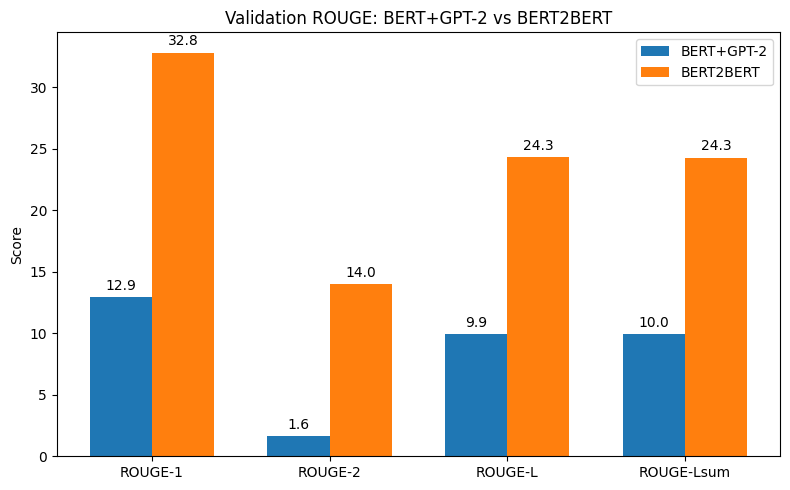

In [ ]:
# Bar chart comparing ROUGE metrics for two models

# Metrics
metrics = {
    "ROUGE-1": {"BERT+GPT-2": 12.91312694945585, "BERT2BERT": 32.81567018512453},
    "ROUGE-2": {"BERT+GPT-2": 1.6157469439274819, "BERT2BERT": 13.98040731409886},
    "ROUGE-L": {"BERT+GPT-2": 9.930971126698305, "BERT2BERT": 24.311643898080202},
    "ROUGE-Lsum": {"BERT+GPT-2": 9.95997928402687, "BERT2BERT": 24.28170470029026},
}

df = pd.DataFrame(metrics).T  # rows: metrics, cols: models

# Bar chart (single plot)
labels = df.index.tolist()
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, df["BERT+GPT-2"].values, width, label="BERT+GPT-2")
rects2 = ax.bar(x + width/2, df["BERT2BERT"].values, width, label="BERT2BERT")

ax.set_ylabel("Score")
ax.set_title("Validation ROUGE: BERT+GPT-2 vs BERT2BERT")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars with values
def autolabel(rects):
    for r in rects:
        height = r.get_height()
        ax.annotate(f"{height:.1f}",
                    xy=(r.get_x() + r.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom")

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig(png_path, bbox_inches="tight")

**Histogram Key Observations**

On small SAMSum subset (~800/200/200), BERT2BERT (patrickvonplaten/bert2bert_cnn_daily_mail) clearly outperforms BERT encoder + GPT-2 decoder on every summarization metric:

ROUGE-1: 32.82 vs 12.91 (+19.90 abs, ~+154%)

ROUGE-2: 13.98 vs 1.62 (+12.36 abs, ~+765%)

ROUGE-L: 24.31 vs 9.93 (+14.38 abs, ~+145%)

ROUGE-Lsum: 24.28 vs 9.96 (+14.32 abs, ~+144%)

Eval loss: 3.37 vs 4.89 (lower is better; ~-31% relative)

Throughput was slightly better for BERT2BERT as well (samples/second 4.8 vs 4.5; steps/second 0.6 vs 0.56), with similar generation lengths (45-49 tokens) and runtime per eval (41–44s).

Conclusion

BERT2BERT is the better model for Project 3: ACME on this setup. It delivers substantially higher ROUGE scores (2–8× improvement depending on metric) and lower evaluation loss with comparable latency. Recommendation: proceed with BERT2BERT as the baseline; use it for further hyperparameter tuning (beam size, length penalty) and ablations (subset size, label smoothing, checkpoint choice).

**Comparisson Summary**

Based on evaluation, BERT2BERT substantially outperforms the BERT+GPT-2 variant across all ROUGE metrics (2–8× higher) and achieves lower evaluation loss, indicating both stronger overlap with reference summaries and more stable training dynamics. Given this clear quantitative advantage, it is not worth continuing with both architectures. We will move forward using BERT2BERT only and focus on sensitivity analyses (beam size, max generation length, label smoothing, etc.) to further improve its performance.

To complement automated metrics, we will incorporate human judgment on 2–3 validation dialogues, assessing clarity, conciseness, and faithfulness of the generated summaries. Success will be defined as producing outputs that are understandable and aligned with the original dialogue in most cases.

We will not include efficiency metrics (runtime or compression ratio) at this stage, since the compression ratio (~20–30% target) does not reliably reflect summary quality. These metrics will only be revisited with the final chosen model to confirm user-facing performance, once content quality is established.

**Save the best Model in my google drive**

This step was included to avoid to rerun the full training everytime the session is close since the parameters will be saved for future analisys and comparisson.

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/bert2bert_samsum_checkpoint"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Save model + tokenizer (Hugging Face way)
model.save_pretrained(SAVE_DIR)              # writes config + weights (.bin or .safetensors)
tokenizer.save_pretrained(SAVE_DIR)

# 2) If you used a HuggingFace Trainer, also save trainer state/checkpoints
try:
    trainer.save_model(SAVE_DIR)             # (also saves tokenizer if trainer.tokenizer is set)
    trainer.state.save_to_json(os.path.join(SAVE_DIR, "trainer_state.json"))
except NameError:
    pass  # you didn't instantiate a Trainer; ignore

# 3) (Optional but recommended) Save your tokenized datasets to skip reprocessing later
try:
    tokenized_train.save_to_disk(os.path.join(SAVE_DIR, "ds_train"))
    tokenized_val.save_to_disk(os.path.join(SAVE_DIR, "ds_val"))
except Exception as e:
    print("Skipped dataset save:", e)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving the dataset (0/1 shards):   0%|          | 0/14731 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/818 [00:00<?, ? examples/s]

# Optimization Phase

**Justification**

After selecting BERT2BERT as the superior model, the next step is systematic optimization. To structure this process, we divided our work into two complementary phases:

Phase A – Training Hyperparameters
In this phase, we adjust core training settings such as learning rate, label smoothing, and weight decay. These parameters directly influence how well the model learns from the data and generalizes to unseen dialogues. Exploring a small grid of these values allows us to identify a stable configuration that balances convergence speed, robustness, and model quality.

Phase B – Decoding Parameters
Once the best training setup is chosen, we focus on decoding strategies. Parameters such as beam size, maximum generation length, no-repeat n-gram size, and length penalty govern how the model generates summaries at inference time. Optimizing these does not require retraining and has a large impact on summary fluency, diversity, and conciseness. This separation ensures we first obtain a strong trained model (Phase A), and then maximize its utility during generation (Phase B).

Data Strategy
Throughout both phases, we will continue to work with the small sampled dataset (≈800/200/200). This approach provides faster turnaround times, making it feasible to run multiple sensitivity tests within our Colab compute limits. Once an optimum configuration is identified, we will scale up to the full dataset for final training and evaluation.

To ensure comparability and efficient resource use, we kept the early stopping configuration constant across all optimization experiments. Specifically, early stopping monitored ROUGE-L, with patience = 2 and load_best_model_at_end = True. The training budget was fixed at 800 steps (3 epochs aprox. on the small dataset), allowing fair comparison of different hyperparameter settings in Phase A. This consistency ensures that differences in performance are attributable to the hyperparameters under test, not to variations in stopping criteria or epoch length. In Phase B, which focuses only on decoding strategies, no retraining is performed, so early stopping is not applied.

# End of Notebook Variant 1

To optimize resource usage, I will create a second notebook variant that focuses exclusively on the BERT2BERT model. All code and configurations related to the discarded BERT+GPT2 baseline will be removed. This simplification ensures that GPU memory and compute are dedicated solely to the selected architecture, reducing overhead and making training runs more efficient for Phase A and Phase B.

Both notebook variants will be retained in the repository:

- Notebook Variant 1 documents the full experimental process, including the comparison of candidate models.

- Notebook Variant 2 serves as the streamlined workflow for continued optimization and final training of BERT2BERT.

This approach preserves reproducibility and transparency (via Variant 1) while enabling efficient, focused experimentation (via Variant 2) and optimize my GPU quote.